In [1]:
import torch.cuda
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import numpy as np
import wandb
import seaborn as sns
from torch import nn


with open('secrets/wandb_api_key.txt') as f:
    wandb.login(key=f.read())

wandb: Currently logged in as: marcus-messer (messer). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/marcus/.netrc


### Train pre-trained model from hugging face
#### Load Dataset

In [7]:
ds = Dataset.load_from_disk('data/code_search_net_relevance.hf')
ds

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text'],
    num_rows: 315
})

#### Load tokenizer and preprocess

In [52]:
# PRETRAINED_MODEL = 'distilbert-base-uncased'
PRETRAINED_MODEL = 'microsoft/codebert-base'

In [55]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

def preprocess(data):
    return tokenizer(data['text'], truncation=True, padding=True)

data_tokens = ds.map(preprocess)
data_tokens

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 315
})

In [56]:
data_tokens = data_tokens.remove_columns(['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens'])
data_tokens

Dataset({
    features: ['func_code_string', 'func_documentation_string', 'label', 'input_ids', 'attention_mask'],
    num_rows: 315
})

<Axes: xlabel='label', ylabel='count'>

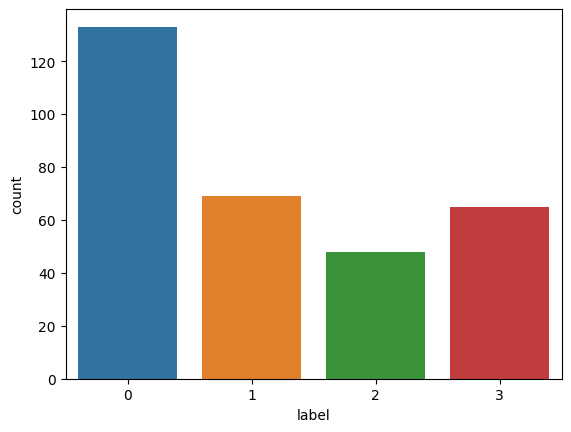

In [57]:
sns.countplot(data_tokens.to_pandas(), x='label')

In [5]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [75]:
tokenizer.decode(data_tokens['input_ids'][0])

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

#### Evaluate

In [34]:
f1 = evaluate.load('f1')
accuracy = evaluate.load('accuracy')
recall = evaluate.load('recall')
precision = evaluate.load('precision')

In [44]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_res = accuracy.compute(predictions=predictions, references=labels)
    f1_macro_res = f1.compute(predictions=predictions, references=labels, average='macro')
    f1_micro_res = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_weighted_res = f1.compute(predictions=predictions, references=labels, average='weighted')
    recall_macro_res = recall.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_res = recall.compute(predictions=predictions, references=labels, average='micro')
    recall_weighted_res = recall.compute(predictions=predictions, references=labels, average='weighted')
    precision_macro_res = precision.compute(predictions=predictions, references=labels, average='macro')
    precision_micro_res = precision.compute(predictions=predictions, references=labels, average='micro')
    precision_weighted_res = precision.compute(predictions=predictions, references=labels, average='weighted')

    return {'accuracy': accuracy_res,
            'f1_macro': f1_macro_res, 'f1_micro': f1_micro_res, 'f1_weighted': f1_weighted_res,
            'recall_macro': recall_macro_res, 'recall_micro': recall_micro_res, 'recall_weighted': recall_weighted_res,
            'precision_macro': precision_macro_res, 'precision_micro': precision_micro_res, 'precision_weighted': precision_weighted_res
            }

#### Split train and test set

In [15]:
ds_split = data_tokens.train_test_split(test_size=0.2)
ds_split

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 252
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 63
    })
})

<Axes: xlabel='label', ylabel='count'>

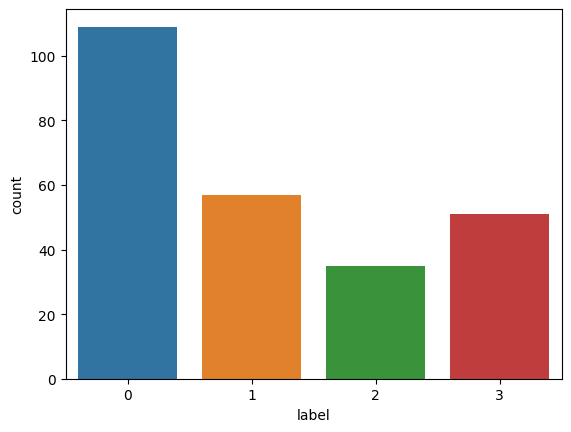

In [16]:
sns.countplot(ds_split['train'].to_pandas(), x='label')

<Axes: xlabel='label', ylabel='count'>

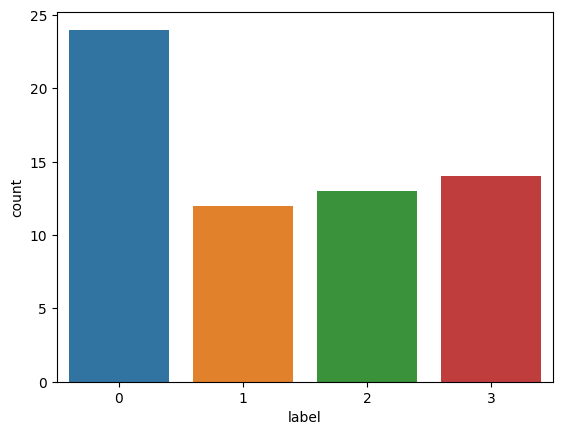

In [17]:
sns.countplot(ds_split['test'].to_pandas(), x='label')

#### Train

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 2.0, 2.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [10]:
id2label = {0: 'irrelevant', 1: 'partially relevant', 2: 'relevant', 3: 'very relevant'}
label2id = {'irrelevant': 0, 'partially relevant': 1, 'relevant': 2, 'very relevant': 3}

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=4, id2label=id2label, label2id=label2id)
model.to(device)


training_arguments = TrainingArguments(
    output_dir='m-messer/JavaDoc_Code_Relevance_Classifier',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=5,
    push_to_hub=False,
    report_to=["wandb"]
)

trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=ds_split["train"],
    eval_dataset=ds_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/marcus/workspace/Programming/JavaDoc_Code_Similarity/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 14.29 GB, other allocations: 3.93 GB, max allowed: 18.13 GB). Tried to allocate 24.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).